In [1]:
import math as m
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = -2 * m.pi * torch.rand(train_data_length) + \
                    2 * m.pi * torch.rand(train_data_length)
train_data[:, 1] = (torch.sin(train_data[:, 0]) / train_data[:, 0]) - \
                   (train_data[:, 0] / 10)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

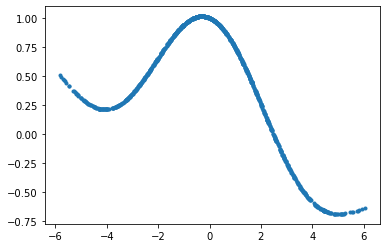

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
               train_set, batch_size=batch_size, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [9]:
generator = Generator()

In [10]:
lr = 0.001  # здесь имеет решающее значение
num_epochs = 310
loss_function = nn.BCELoss()

In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
                            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
                             output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
                         output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 60 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.06578028947114944
Epoch: 0 Loss G.: 2.995394229888916
Epoch: 60 Loss D.: 0.6618058085441589
Epoch: 60 Loss G.: 0.7609315514564514
Epoch: 120 Loss D.: 0.6845045685768127
Epoch: 120 Loss G.: 0.6965623497962952
Epoch: 180 Loss D.: 0.6914818286895752
Epoch: 180 Loss G.: 0.6941553354263306
Epoch: 240 Loss D.: 0.6907799243927002
Epoch: 240 Loss G.: 0.7282283902168274
Epoch: 300 Loss D.: 0.6777489185333252
Epoch: 300 Loss G.: 0.7428454756736755


In [13]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

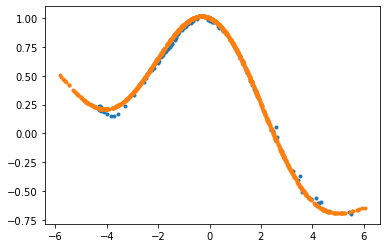

In [14]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.plot(train_data[:, 0], train_data[:, 1], ".")